# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [3]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-05-19/data_eval_new/"
file_name = "int_norm_20160519_bgd_old.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [4]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [5]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [6]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

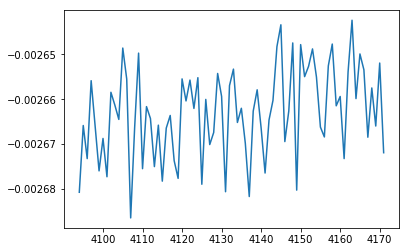

In [7]:
# Check Baselines
column = "117"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

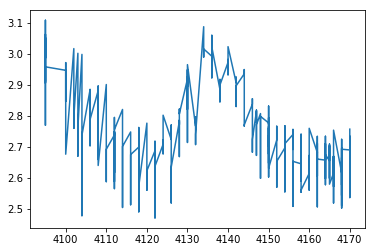

In [8]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

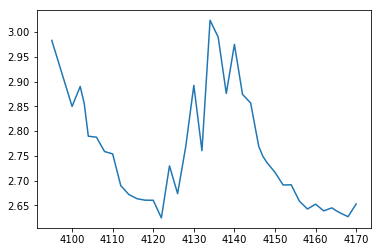

In [9]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

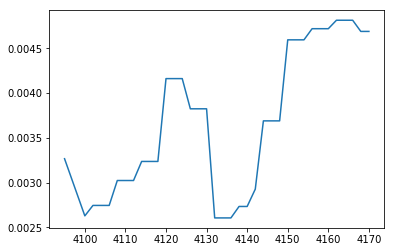

In [10]:
# Check background 
column = "118"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [11]:
background_mean = df_mean(background)

# Outlier rejection

In [12]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_122_118"
interf_corr = "Te125_Xe129_corr"

In [13]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [14]:
column = "124/118"
sample = "NIST 200ppb"

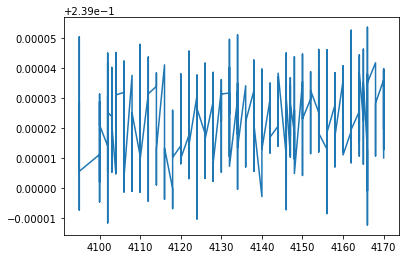

In [15]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [16]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [17]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,,,
2016-05-19 16:52:00,NIST 200ppb,2,1,4095,0.040139,0.027185,0.013941,0.600310,0.316699,0.354630,1.345916,0.19125,0.239014
2016-05-19 16:52:00,NIST 200ppb,2,2,4095,0.040135,0.027172,0.013942,0.600274,0.316702,0.354621,1.345961,0.19125,0.239028
2016-05-19 16:52:00,NIST 200ppb,2,3,4095,0.040139,0.027174,0.013944,0.600300,0.316710,0.354611,1.345936,0.19125,0.239002
2016-05-19 16:52:00,NIST 200ppb,2,4,4095,0.040135,0.027173,0.013950,0.600315,0.316707,0.354626,1.345914,0.19125,0.239017
2016-05-19 16:52:00,NIST 200ppb,2,5,4095,0.040142,NaN,0.013951,0.600307,0.316711,0.354614,1.345956,0.19125,0.239009
2016-05-19 16:52:00,NIST 200ppb,2,6,4095,0.040136,0.027178,0.013944,0.600299,0.316716,0.354612,1.345929,0.19125,0.239003
2016-05-19 16:52:00,NIST 200ppb,2,7,4095,0.040140,0.027179,0.013945,0.600334,0.316714,0.354631,1.345938,0.19125,0.239013
2016-05-19 16:52:00,NIST 200ppb,2,8,4095,0.040136,0.027176,0.013951,0.600300,0.316704,0.354609,1.345939,0.19125,0.239001
2016-05-19 16:52:00,NIST 200ppb,2,9,4095,0.040134,0.027171,0.013948,0.600327,0.316726,0.354619,1.345943,0.19125,0.239010


In [18]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
4097        2016-05-19 17:16:00    0.258537
            2016-05-19 17:16:00    0.258554
4100        2016-05-19 17:49:00    0.259002
4106        2016-05-19 19:09:00    0.259125
4109        2016-05-19 19:47:00    0.259163
4111        2016-05-19 20:15:00    0.259217
            2016-05-19 20:15:00    0.259222
4112        2016-05-19 20:29:00    0.259175
4140        2016-05-20 02:41:00    0.259442
            2016-05-20 02:41:00    0.259379
4147        2016-05-20 04:11:00    0.259584
4163        2016-05-20 07:43:00    0.259614
Name: 124/118, dtype: float64

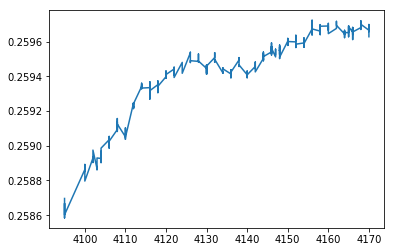

In [19]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [20]:
df[df["Sample"] == sample][column].std()

0.00026836305902802675

In [21]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

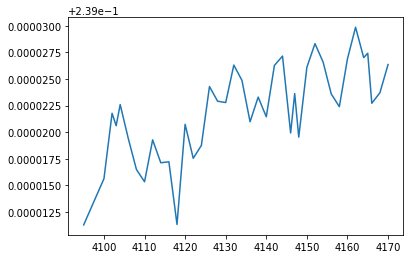

In [22]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [23]:
data_mean_int

,Filenumber,Sample,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,
2016-05-19 16:52:00,4095,NIST 200ppb,0.040137,0.027174,0.013946,0.600305,0.316713,0.354621,1.345943,0.19125,0.239011
2016-05-19 17:16:00,4097,NIST 350ppb,0.040136,0.027173,0.013944,0.600301,0.316711,0.354616,1.345919,0.19125,0.239017
2016-05-19 17:49:00,4100,NIST 200ppb,0.040138,0.027175,0.013945,0.600305,0.316714,0.354618,1.345944,0.19125,0.239016
2016-05-19 18:13:00,4102,NIST 200ppb,0.040141,0.027178,0.013945,0.600310,0.316708,0.354612,1.345955,0.19125,0.239022
2016-05-19 18:27:00,4103,NIST 200ppb,0.040140,0.027178,0.013944,0.600306,0.316711,0.354616,1.345949,0.19125,0.239021
2016-05-19 18:41:00,4104,NIST 200ppb,0.040143,0.027181,0.013944,0.600306,0.316711,0.354612,1.345939,0.19125,0.239023
2016-05-19 18:55:00,4105,NIST 350ppb,0.040141,0.027178,0.013944,0.600317,0.316712,0.354614,1.345917,0.19125,0.239021
2016-05-19 19:09:00,4106,NIST 200ppb,0.040143,0.027178,0.013945,0.600318,0.316716,0.354613,1.345952,0.19125,0.239019
2016-05-19 19:33:00,4108,NIST 200ppb,0.040144,0.027182,0.013945,0.600316,0.316713,0.354611,1.345931,0.19125,0.239016


In [36]:
date_list = []
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [37]:
drop_sum = []
data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [38]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [39]:
data_mean_int_sum

112/118                       114/118            \
                              mean           SD2 count      mean       SD2   
Sample                                                                       
Allende HP 1_1            0.040146           NaN     1  0.027178       NaN   
Allende bomb 1_1          0.040146           NaN     1  0.027182       NaN   
NIST + Cd ns 1            0.040146           NaN     1  0.027181       NaN   
NIST 200ppb               0.040145  5.766161e-06    40  0.027179  0.000006   
NIST 200ppb + 0.005ppb U  0.040146  9.328565e-07     2  0.027182  0.000001   
NIST 200ppb + 0.02ppb Mo  0.040146  4.163732e-06     2  0.027181  0.000004   
NIST 200ppb + 0.03ppb Cd  0.040146  3.920844e-06     3  0.027180  0.000008   
NIST 200ppb + 0.6ppb Pd   0.040147  3.329309e-06     2  0.027182  0.000003   
NIST 350ppb               0.040142  7.992713e-06     5  0.027177  0.000005   
ZH09-05 23.3_1_3          0.040147           NaN     1  0.027182       NaN   
ZH09-05 23.3_1_4          0.040146           NaN     1  0.027179       NaN   
ZH09-05 44.8_1_2          0.040146           NaN     1  0.027178       NaN   

                                 115/118                   116/118  ...   \
                         count      mean       SD2 count      mean  ...    
Sample                                                              ...    
Allende HP 1_1               1  0.013944       NaN     1  0.600333  ...    
Allende bomb 1_1             1  0.013942       NaN     1  0.600327  ...    
NIST + Cd ns 1               1  0.013944       NaN     1  0.600333  ...    
NIST 200ppb                 40  0.013945  0.000002    40  0.600328  ...    
NIST 200ppb + 0.005ppb U     2  0.013944  0.000002     2  0.600336  ...    
NIST 200ppb + 0.02ppb Mo     2  0.013946  0.000001     2  0.600336  ...    
NIST 200ppb + 0.03ppb Cd     3  0.013944  0.000001     3  0.600334  ...    
NIST 200ppb + 0.6ppb Pd      2  0.013945  0.000002     2  0.600332  ...    
NIST 350ppb                  5  0.013945  0.000002     5  0.600323  ...    
ZH09-05 23.3_1_3             1  0.013942       NaN     1  0.600320  ...    
ZH09-05 23.3_1_4             1  0.013944       NaN     1  0.600329  ...    
ZH09-05 44.8_1_2             1  0.013944       NaN     1  0.600325  ...    

                         119/118   120/118                  122/118  \
                           count      mean       SD2 count     mean   
Sample                                                                
Allende HP 1_1                 1  1.345916       NaN     1  0.19125   
Allende bomb 1_1               1  1.345935       NaN     1  0.19125   
NIST + Cd ns 1                 1  1.345944       NaN     1  0.19125   
NIST 200ppb                   40  1.345936  0.000016    40  0.19125   
NIST 200ppb + 0.005ppb U       2  1.345932  0.000004     2  0.19125   
NIST 200ppb + 0.02ppb Mo       2  1.345931  0.000010     2  0.19125   
NIST 200ppb + 0.03ppb Cd       3  1.345925  0.000015     3  0.19125   
NIST 200ppb + 0.6ppb Pd        2  1.345933  0.000009     2  0.19125   
NIST 350ppb                    5  1.345907  0.000023     5  0.19125   
ZH09-05 23.3_1_3               1  1.345940       NaN     1  0.19125   
ZH09-05 23.3_1_4               1  1.345928       NaN     1  0.19125   
ZH09-05 44.8_1_2               1  1.345945       NaN     1  0.19125   

                                               124/118                  
                                   SD2 count      mean       SD2 count  
Sample                                                                  
Allende HP 1_1                     NaN     1  0.239021       NaN     1  
Allende bomb 1_1                   NaN     1  0.239023       NaN     1  
NIST + Cd ns 1                     NaN     1  0.239025       NaN     1  
NIST 200ppb               8.479468e-17    40  0.239022  0.000009    40  
NIST 200ppb + 0.005ppb U  5.551115e-17     2  0.239024  0.000014     2  
NIST 200ppb + 0.02ppb Mo  1.570092e-16     2  0.239021  0.000010 

In [61]:
date_list = []


epsilon_int_200 = SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)

In [62]:

date_list = [pd.Timestamp('2016-05-19 21:49:00')]

epsilon_int_200 = epsilon_int_200.drop(date_list)
delta_raw_200 = delta_raw_200.drop(date_list)

In [63]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -5) & (df["Filenumber"] <= 5)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [64]:
epsilon_int_200 = epsilon_process(epsilon_int_200)
delta_raw_200 = epsilon_process(delta_raw_200)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
epsilon_int_200

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-05-19 17:16:00,4097,-0.310960,-0.415567,-1.034175,-0.067258,-0.071780,-0.098794,-0.178950,-3.330669e-12,0.138538,NIST 350ppb
2016-05-19 17:49:00,4100,-0.364216,-0.516814,-0.168508,-0.046102,0.111876,0.052734,-0.041717,-4.440892e-12,-0.037685,NIST 200ppb
2016-05-19 18:13:00,4102,0.721929,0.769724,0.085510,0.068568,-0.157476,-0.132907,0.065669,2.220446e-12,0.153046,NIST 200ppb
2016-05-19 18:27:00,4103,-0.624459,-0.622054,-0.194186,-0.027761,0.058031,0.104950,0.013141,4.440892e-12,-0.066023,NIST 200ppb
2016-05-19 18:41:00,4104,0.382430,1.038597,-0.166763,-0.095042,-0.069349,-0.078044,-0.084381,-4.440892e-12,0.108459,NIST 200ppb
2016-05-19 18:55:00,4105,-0.361277,-0.413552,-0.260645,0.079914,-0.029559,0.041582,-0.215876,4.440892e-12,0.017609,NIST 350ppb
2016-05-19 19:09:00,4106,-0.185146,-1.153669,0.144176,0.110164,0.115191,0.057992,0.127844,-1.110223e-12,-0.006223,NIST 200ppb
2016-05-19 19:33:00,4108,0.144447,0.735375,-0.048008,-0.056914,-0.154515,-0.076934,-0.155657,4.440892e-12,-0.036537,NIST 200ppb
2016-05-19 19:47:00,4109,-0.387023,-0.945699,0.471045,0.097868,-0.111374,-0.042056,-0.253916,-3.330669e-12,0.132152,NIST 350ppb


In [66]:
epsilon_int_200_sum = np.round(epsilon_int_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_200_sum = np.round(delta_raw_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_int_200_sum
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_200_sum
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [67]:
epsilon_sum_all

112/118              114/118              115/118  \
                            mean    SD2 count    mean    SD2 count    mean   
Sample                                                                       
Allende HP 1_1            -0.091    NaN     1   0.051    NaN     1  -0.975   
Allende bomb 1_1           0.188    NaN     1   1.718    NaN     1  -2.891   
NIST + Cd ns 1            -0.603    NaN     1  -0.672    NaN     1  -1.011   
NIST 200ppb               -0.040  1.004    37  -0.038  1.705    37  -0.015   
NIST 200ppb + 0.005ppb U   0.284  0.153     2   0.392  0.815     2  -0.913   
NIST 200ppb + 0.02ppb Mo  -0.019  0.425     2  -0.327  0.680     2   0.948   
NIST 200ppb + 0.03ppb Cd   0.070  0.177     3   0.444  0.771     3  -0.693   
NIST 200ppb + 0.6ppb Pd    0.089  0.117     2  -0.111  0.028     2   0.407   
NIST 350ppb               -0.164  0.669     5  -0.227  1.564     5  -0.142   
ZH09-05 23.3_1_3           0.690    NaN     1   0.783    NaN     1  -1.342   
ZH09-05 23.3_1_4          -0.062    NaN     1  -0.056    NaN     1  -1.774   
ZH09-05 44.8_1_2           0.067    NaN     1  -0.059    NaN     1  -1.256   

                                      116/118  ...  119/118 120/118         \
                            SD2 count    mean  ...    count    mean    SD2   
Sample                                         ...                           
Allende HP 1_1              NaN     1   0.095  ...        1  -0.136    NaN   
Allende bomb 1_1            NaN     1  -0.100  ...        1   0.017    NaN   
NIST + Cd ns 1              NaN     1  -0.082  ...        1   0.063    NaN   
NIST 200ppb               1.077    37  -0.003  ...       37   0.001  0.125   
NIST 200ppb + 0.005ppb U  0.113     2   0.051  ...        2   0.000  0.020   
NIST 200ppb + 0.02ppb Mo  0.135     2   0.112  ...        2  -0.068  0.018   
NIST 200ppb + 0.03ppb Cd  1.454     3   0.034  ...        3  -0.037  0.046   
NIST 200ppb + 0.6ppb Pd   0.678     2  -0.009  ...        2  -0.008  0.055   
NIST 350ppb               1.347     5   0.042  ...        5  -0.257  0.126   
ZH09-05 23.3_1_3            NaN     1  -0.144  ...        1   0.074    NaN   
ZH09-05 23.3_1_4            NaN     1  -0.068  ...        1  -0.020    NaN   
ZH09-05 44.8_1_2            NaN     1   0.006  ...        1   0.080    NaN   

                               122/118            124/118               
                         count    mean  SD2 count    mean    SD2 count  
Sample                                                                  
Allende HP 1_1               1    -0.0  NaN     1  -0.197    NaN     1  
Allende bomb 1_1             1     0.0  NaN     1  -0.003    NaN     1  
NIST + Cd ns 1               1    -0.0  NaN     1   0.095    NaN     1  
NIST 200ppb                 37    -0.0  0.0    37   0.010  0.235    37  
NIST 200ppb + 0.005ppb U     2     0.0  0.0     2   0.075  0.245     2  
NIST 200ppb + 0.02ppb Mo     2     0.0  0.0     2  -0.058  0.147     2  
NIST 200ppb + 0.03ppb Cd     3    -0.0  0.0     3  -0.041  0.217     3  
NIST 200ppb + 0.6ppb Pd      2    -0.0  0.0     2   0.001  0.128     2  
NIST 350ppb                  5     0.0  0.0     5   0.053  0.153     5  
ZH09-05 23.3_1_3             1    -0.0  NaN     1   0.168    NaN     1  
ZH09-05 23.3_1_4             1    -0.0  NaN     1  -0.024    NaN     1  
ZH09-05 44.8_1_2             1    -0.0  NaN     1   0.061    NaN     1  

[12 rows x 27 columns]

In [192]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

# Raw data to xls file

In [91]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [92]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [193]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_new.xlsx', engine='xlsxwriter')


In [194]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_200.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_200.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [195]:
writer_orig.save()

In [199]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [200]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')